# Optimization Problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
sns.set_theme(context='paper', palette='colorblind', style='whitegrid')

## From Motzkin (1955)

The feasibility probability is given by 
$$
    p(N,K) = 2^{-N} \sum_{k=0}^K \binom{N}{k}
$$

For $K \geq N$, we have $p(N,K) = 1$.

**Notes.** The feasibility probability can scale in a better way as the inequalities are strongly correlated to each others (at least for short spike trains). For larger spike trains, the further away (in time) two inequalities are, the less correlated they are, and thus the statistical assumption might be good enough.

In [4]:
from scipy.special import binom

In [5]:
p = lambda n, k: np.power(2.,-n) * np.sum(binom(n, np.arange(k+1)))

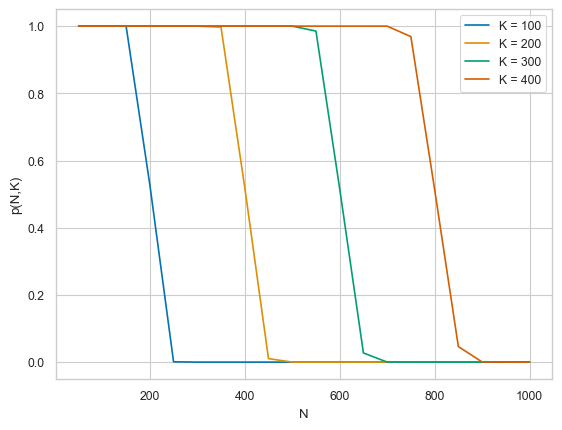

In [6]:
ns = np.arange(50,1050,50)
for k in np.arange(100,500,100):
    ps = [p(n, k) for n in ns]
    plt.plot(ns, ps, label=f"K = {k}")

plt.ylabel("p(N,K)")
plt.xlabel("N")
plt.legend()
plt.show()

## TODO
The storage capacity of a neuron is given by the longest spike train it can perfectly memorized, parametrized by the number of inequalities $N$ in the LP **with probability close to 1**, as a function of its number of inputs $K$.
We would like **at least a linear scaling**, for the capacity per received input to be non-vanishing.

In [7]:
p(100 + 400, 400)

0.9999999999998325

If $N = \alpha_T T + \alpha_K K$, we can identify $\alpha_T$ and $\alpha_K$ by finding points where $p(N,K) = 1/2$ which is supposed to be at $N = 2K + 1$.

## Constrained Optimization

In [24]:
import gurobipy as gp

### Linear Program w/o Objective Function

In [25]:
from rsnn.optim.irls import solve_lp

In [53]:
def solve_lp_gurobi(A, b, xb):
    _, K = A.shape
    
    model_gp = gp.Model()
    
    x_gp = model_gp.addMVar(shape=K, lb=-xb, ub=xb)
    model_gp.addConstr(A @ x_gp <= b)
    
    model_gp.optimize()
    
    xhat = x_gp.X
    
    status = f"{'All constraints are' if np.all(A@xhat <= b) and np.all(np.abs(xhat) <= xb) else 'Some constraints are not'} satisfied."
    return xhat, status

In [54]:
N, K = 10, 5
xb = 1

x = np.random.uniform(-xb,xb,K)
A = np.random.normal(size=(N,K))
b = A@x + np.random.uniform(0,2,N)

In [55]:
xhat, status = solve_lp(A, b, xb)
print(status)

  0%|          | 0/1000 [00:00<?, ?it/s]

Converged in 5 iterations. All constraints are satisfied.


In [56]:
xhat, status = solve_lp_gurobi(A, b, xb)
print(status)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10 rows, 5 columns and 50 nonzeros
Model fingerprint: 0x510206b4
Coefficient statistics:
  Matrix range     [3e-02, 3e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-02, 2e+00]
Presolve time: 0.01s
Presolved: 10 rows, 5 columns, 50 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.051907e+00   0.000000e+00      0s
       5    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  0.000000000e+00
All constraints are satisfied.


### Linear Program with L2 Regularization

In [57]:
from rsnn.optim.irls import solve_lp_l2

In [63]:
def solve_lp_l2_gurobi(A, b, xb):
    _, K = A.shape
    
    model_gp = gp.Model()
    x_gp = model_gp.addMVar(shape=K, lb=-xb, ub=xb)
    model_gp.addConstr(A @ x_gp <= b)

    lp_norm = model_gp.addVar()
    model_gp.addConstr(lp_norm == gp.norm(x_gp, 2))
    objective = lp_norm
    model_gp.setObjective(objective, gp.GRB.MINIMIZE)
    
    model_gp.optimize()

    xhat = x_gp.X
    
    status = f"{'All constraints are' if np.all(A@xhat <= b) and np.all(np.abs(xhat) <= xb) else 'Some constraints are not'} satisfied. L2 regularization: {np.mean(np.square(xhat))}"
    return xhat, status

In [64]:
N, K = 10, 5
xb = 1

x = np.random.uniform(-xb,xb,K)
A = np.random.normal(size=(N,K))
b = A@x + np.random.uniform(0,2,N)

In [100]:
xhat, status = solve_lp_l2(A, b, xb, l2_reg=2.4)
print(status)

  0%|          | 0/5000 [00:00<?, ?it/s]

Converged in 38 iterations. Some constraints are not satisfied. L2 regularization: 0.14920566384980744


In [66]:
xhat, status = solve_lp_l2_gurobi(A, b, xb)
print(status)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 10 rows, 6 columns and 50 nonzeros
Model fingerprint: 0x448dba6a
Model has 1 general constraint
Variable types: 6 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [9e-03, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 2e+00]
Presolve removed 2 rows and 0 columns
Presolve time: 0.01s
Presolved: 9 rows, 11 columns, 46 nonzeros
Presolved model has 5 quadratic constraint(s)
Variable types: 11 continuous, 0 integer (0 binary)
Root relaxation presolve time: 0.02s
Root relaxation presolved: 29 rows, 21 columns, 86 nonzeros
Root relaxation presolved model has 5 second-order cone constraints
Root barrier log...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.680e+02
 Factor NZ  : 4.010e+02
 Factor Ops : 7.195e+03 (less 

In [16]:
N, K = 100, 5
xb = 1

x = np.random.uniform(-xb,xb,K)
A = np.random.normal(size=(N,K))
b = A@x + np.random.uniform(0,2,N)

xhat, status = solve_lp_l2(A, b, xb, l2_reg=5e-2)
print(status)

  0%|          | 0/5000 [00:00<?, ?it/s]

Converged in 1906 iterations. Some constraints are not satisfied. L2 regularization: 0.2491375239596793


In [19]:
N, K = 10, 50
xb = 1

x = np.random.uniform(-xb,xb,K)
A = np.random.normal(size=(N,K))
b = A@x + np.random.uniform(0,2,N)

xhat, status = solve_lp_l2(A, b, xb)
print(status)

  0%|          | 0/5000 [00:00<?, ?it/s]

Converged in 44 iterations. All constraints are satisfied.


### Linear Program with L1 Regularization

In [ ]:
from rsnn.optim.irls import solve_lp

In [ ]:
N, K = 10, 5
xb = 1

x = np.random.uniform(-xb,xb,K)
A = np.random.normal(size=(N,K))
b = A@x + np.random.uniform(0,2,N)

xhat, status = solve_lp(A, b, xb)
print(status)

In [ ]:
N, K = 1000, 5
xb = 1

x = np.random.uniform(-xb,xb,K)
A = np.random.normal(size=(N,K))
b = A@x + np.random.uniform(0,2,N)

xhat, status = solve_lp(A, b, xb)
print(status)

In [ ]:
N, K = 300, 500
xb = 1

x = np.random.uniform(-xb,xb,K)
A = np.random.normal(size=(N,K))
b = A@x + np.random.uniform(0,2,N)

xhat, status = solve_lp(A, b, xb)
print(status)

### Linear Program with Quantized Variables

In [ ]:
from rsnn.optim.irls import solve_lp

In [ ]:
N, K = 10, 5
xb = 1

x = np.random.uniform(-xb,xb,K)
A = np.random.normal(size=(N,K))
b = A@x + np.random.uniform(0,2,N)

xhat, status = solve_lp(A, b, xb)
print(status)

In [ ]:
N, K = 1000, 5
xb = 1

x = np.random.uniform(-xb,xb,K)
A = np.random.normal(size=(N,K))
b = A@x + np.random.uniform(0,2,N)

xhat, status = solve_lp(A, b, xb)
print(status)

In [ ]:
N, K = 300, 500
xb = 1

x = np.random.uniform(-xb,xb,K)
A = np.random.normal(size=(N,K))
b = A@x + np.random.uniform(0,2,N)

xhat, status = solve_lp(A, b, xb)
print(status)